## Access GSLA Sea Level Anomaly data in Zarr
A jupyter notebook to show how to access and plot the AODN model_sea_level_anomaly_gridded_realtime dataset available as a [Zarr](https://zarr.dev/)  dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/0c9eb39c-9cbe-4c6a-8a10-5867087e703a).

In [1]:
dataset_name="model_sea_level_anomaly_gridded_realtime"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 31ms


✅ Local version 0.2.2 is up to date (remote: 0.2.2)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.zarr'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 425 ms, sys: 60 ms, total: 485 ms
Wall time: 1.11 s


In [5]:
ds = aodn_dataset.zarr_store
ds.info()

xarray.Dataset {
dimensions:
	TIME = 100 ;
	LATITUDE = 351 ;
	LONGITUDE = 641 ;

variables:
	float64 GSL(TIME, LATITUDE, LONGITUDE) ;
		GSL:description = GSLA + CAST2008 mean dynamic height  ;
		GSL:long_name = gridded sea level ;
		GSL:standard_name = sea_surface_height_above_geoid ;
		GSL:units = m ;
	float64 GSLA(TIME, LATITUDE, LONGITUDE) ;
		GSLA:description = Altimeter and tidegauge estimates of adjusted sea level anomaly mapped onto a grid using optimal interpolation (OI). For details of  the temporal and spatial covariance functions of the OI see the Reference. The anomaly field is mapped because the geoid is not known to sufficient precision, obliging us to remove the time-mean from all sea level observations. Sea level minus the tides and inverse barometer (IB) response, rather than total sea level, is mapped because it is the quantity from which geostrophic velocities can be estimated, and because total sea level has too much high-frequency energy to be mapped from altimeter

## Plot time coverage

In [6]:
aodn_dataset.get_temporal_extent()

(Timestamp('2011-09-01 00:00:00'), Timestamp('2011-12-12 00:00:00'))

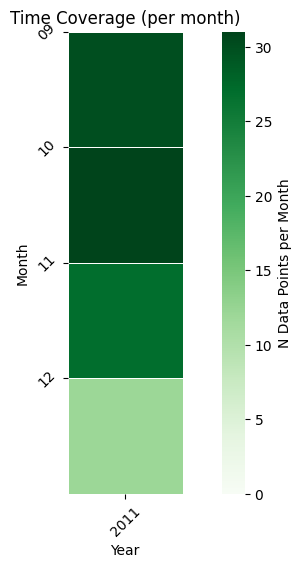

In [7]:
aodn_dataset.plot_time_coverage()

## Plot a gridded variable

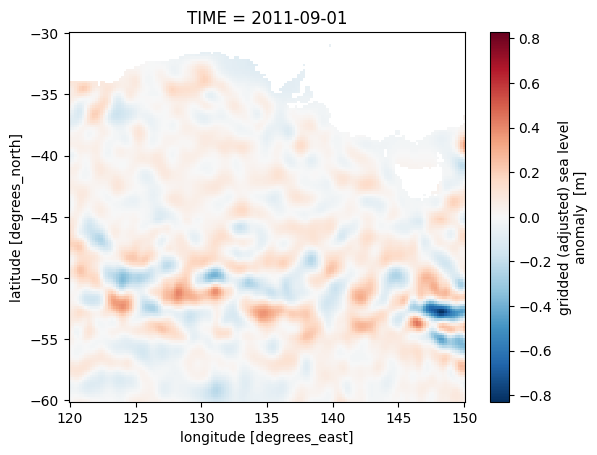

In [8]:
ds.GSLA.sel(TIME='2011-09-01T00:00:00.000000000', LONGITUDE=slice(120, 150), LATITUDE=slice(-60, -30)).plot()  # LATITUDE slice is reversed order from L3S

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import pandas as pd

def plot_gsla_timeseries_subplots(ds, time_start, lon_slice, lat_slice):
    """
    Create subplots of timeseries data over specified time intervals and spatial slices.

    Parameters:
    - ds (xarray.Dataset): Dataset containing the variable of interest (e.g., GSLA).
    - time_start (str): Start time in 'YYYY-MM-DD' format.
    - lon_slice (slice): Longitude slice (e.g., slice(120, 150)).
    - lat_slice (slice): Latitude slice (e.g., slice(-60, -30)).
    """
    ds = ds.sortby("TIME")

    # Parse start time string to datetime
    start_time = pd.to_datetime(time_start)

    # Create a new figure with specified number of subplots in a row
        # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

    # Plot data on each subplot. We're plotting the next 6 time stamps (requiring obviously that they all exist)
    ii = 0
    iTime = list(ds.TIME.values).index(ds.sel(TIME=time_start , method='nearest').TIME)
    cbar_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])  # Adjust the position and size of the colorbar
    
    for i in range(3):
        for j in range(2):
            time_index = iTime + ii
            gsla = ds.GSLA.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            uData = ds.UCUR.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            vData = ds.VCUR.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            lonData = gsla.LONGITUDE.values
            latData = gsla.LATITUDE.values

            cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])

            p = axes[i, j].pcolor(lonData, latData, gsla, cmap=cmap_custom, vmin=-.5, vmax=.5)
            #axes[i, j].quiver(lonData, latData, uData, vData, units='width')
            axes[i, j].set_title(f'{np.datetime_as_string(ds.TIME.values[iTime + ii])}')
            ii += 1

    # Add a common colorbar
    fig.colorbar(p, cax=cbar_ax, label='GSLA')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1827197/2182299496.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


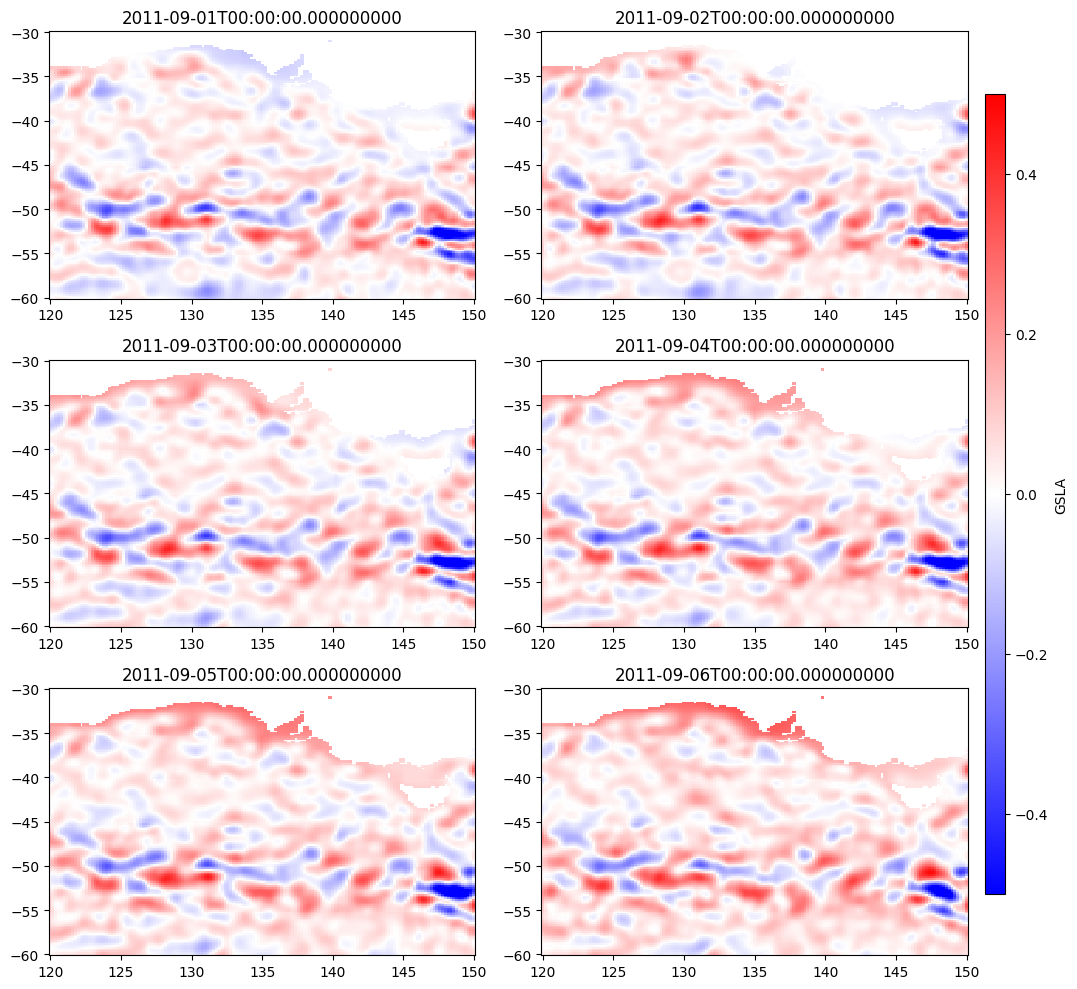

In [10]:
time_start = '2011-03-02'
lon_slice = slice(120, 150)
lat_slice = slice(-60, -30)

plot_gsla_timeseries_subplots(ds, time_start, lon_slice, lat_slice)
